# Touch and User Classification from Smart Fabric

## Köksal Kerem TANIL - 211805018

**Objective:** This project aims to build two separate classification models using data collected from a smart textile sensor array:
1.  Predict the user identity (`user_id`) based on sensor input.
2.  Predict the touch type (`touch_type`) using the same sensor data.

**Dataset:**
*   Contains 2056 samples (touch instances).
*   Features 3200 sensor channels capturing pressure/intensity.
*   Targets: `user_id` (0-29) and `touch_type` (0-9 or more).
*   Auxiliary columns (`touch`, `finger`, `palm`, `fist`) are present but **not used** in this task.

**Constraints:**
*   **NO** dimensionality reduction techniques (PCA, UMAP, t-SNE, Autoencoders).
*   **MUST** use feature selection or ranking techniques.

**Hints:**
*   Handle potential noise/outliers.
*   Remove low-variance/zero columns.
*   Use Pipelines/ColumnTransformer.
*   Compare feature selection methods vs. feature count trade-off.

## 1. Data Loading and Initial Exploration

In this first step, we load the dataset using pandas and perform an initial exploration to understand its structure, data types, and basic properties.

*   Load the CSV file into a DataFrame.
*   Check the dimensions (shape) of the data.
*   Inspect column names and data types (`info()`).
*   Identify target variables (`user_id`, `touch_type`) and feature columns (sensors '1' to '3200').
*   List the columns that will not be used (`unused_columns`).
*   Check for any missing values (`isnull().sum()`).
*   Examine the distribution of the target variables (`value_counts()`) to understand class frequencies and potential imbalance.

In [1]:
import pandas as pd

file_path = 'project_3.csv'
df = pd.read_csv(file_path)

In [3]:
df.shape

(2056, 3206)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2056 entries, 0 to 2055
Columns: 3206 entries, user_id to 3200
dtypes: bool(4), int64(3202)
memory usage: 50.2 MB


In [8]:
target_user = 'user_id'
target_touch = 'touch_type'
print(f"Hedef değişkenler: {target_user}, {target_touch}")

Hedef değişkenler: user_id, touch_type


In [16]:
all_columns = df.columns.tolist()
unused_columns = ['touch', 'finger', 'palm', 'fist']

sensor_columns_numeric = [col for col in df.columns if str(col).isdigit()]
print(f"{len(sensor_columns_numeric)} adet sayısal isimli sütun bulundu (potansiyel sensörler).")

if len(sensor_columns_numeric) != 3200:
             print("Uyarı: Beklenen 3200 sensör sütunu bulunamadı, sütun isimlerini kontrol edin.")
feature_columns = sensor_columns_numeric

print(f"Toplam {len(feature_columns)} adet girdi özelliği (sensör sütunu) belirlendi.")

print(f"İlk 5 özellik sütunu: {feature_columns[:5]}")
print(f"Son 5 özellik sütunu: {feature_columns[-5:]}")
print("-" * 30)

3200 adet sayısal isimli sütun bulundu (potansiyel sensörler).
Toplam 3200 adet girdi özelliği (sensör sütunu) belirlendi.
İlk 5 özellik sütunu: ['1', '2', '3', '4', '5']
Son 5 özellik sütunu: ['3196', '3197', '3198', '3199', '3200']
------------------------------


In [17]:
print(f"Bu görevde kullanılmayacak sütunlar: {unused_columns}")

for col in unused_columns:
    if col not in df.columns:
        print(f"Uyarı: '{col}' sütunu veri setinde bulunamadı.")
print("-" * 30)

Bu görevde kullanılmayacak sütunlar: ['touch', 'finger', 'palm', 'fist']
------------------------------


In [18]:
print("Eksik değer kontrolü:")
missing_values = df.isnull().sum()
print(f"Toplam eksik değer sayısı: {missing_values.sum()}")
if missing_values.sum() > 0:
    print("Eksik değer içeren sütunlar:")
    print(missing_values[missing_values > 0])
else:
    print("Veri setinde eksik değer bulunmamaktadır.")
print("-" * 30)

Eksik değer kontrolü:
Toplam eksik değer sayısı: 0
Veri setinde eksik değer bulunmamaktadır.
------------------------------


In [19]:
print(f"'{target_user}' dağılımı:")
print(df[target_user].value_counts())
print("-" * 30)

print(f"'{target_touch}' dağılımı:")
print(df[target_touch].value_counts())
print("-" * 30)

'user_id' dağılımı:
user_id
7     104
0      85
6      84
28     84
17     83
5      83
23     83
10     81
2      76
25     71
13     69
26     67
21     66
9      65
3      65
8      64
24     64
16     63
11     62
29     61
1      60
19     60
22     60
4      59
18     59
15     57
12     56
27     56
20     55
14     54
Name: count, dtype: int64
------------------------------
'touch_type' dağılımı:
touch_type
0    1144
1     123
8     123
2     112
9     103
7      99
6      92
3      90
5      88
4      82
Name: count, dtype: int64
------------------------------


## 2. Data Preprocessing

Based on the initial exploration and project hints, we perform necessary preprocessing steps to clean the data and prepare it for feature selection and modeling.

1.  **Remove Unused Columns:** Drop the `touch`, `finger`, `palm`, `fist` columns as specified.
2.  **Remove Low-Variance Features:** Use `sklearn.feature_selection.VarianceThreshold` with a threshold of 0.0 to identify and remove sensor columns that have zero variance (i.e., contain the same value for all samples). *Result: Found 0 such columns in this dataset.*
3.  **Handle Outliers (Z-Score Method):** Apply Z-score outlier detection to the sensor features. Samples where *any* sensor reading has a Z-score greater than a chosen threshold will be removed.
    *   *Initial trial with threshold=3 removed >60% of data (too aggressive).*
    *   **Using threshold=4:** Identified and removed 126 outlier samples (~6.13% data loss), leaving 1930 samples. This seems more reasonable.
4.  **Separate Features (X) and Targets (y):** Create the final feature matrix `X` (containing only the selected sensor columns after variance and outlier filtering) and the target vectors `y_user` and `y_touch`.

In [20]:
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import zscore 
import numpy as np
import pandas as pd

print("Adım 2.1: Kullanılmayacak sütunlar çıkarılıyor...")
original_columns = df.columns.tolist()
df_processed = df.drop(columns=unused_columns, errors='ignore')
removed_cols = [col for col in unused_columns if col in original_columns]
if removed_cols:
    print(f"Şu sütunlar çıkarıldı: {removed_cols}")
    feature_columns = [col for col in feature_columns if col not in unused_columns]
else:
    print("Kullanılmayacak sütunlar zaten yoktu veya daha önce çıkarılmıştı.")
print(f"İşlem sonrası DataFrame boyutu: {df_processed.shape}")
print("-" * 30)

Adım 2.1: Kullanılmayacak sütunlar çıkarılıyor...
Şu sütunlar çıkarıldı: ['touch', 'finger', 'palm', 'fist']
İşlem sonrası DataFrame boyutu: (2056, 3202)
------------------------------


In [21]:
print("Adım 2.2: Sıfır varyanslı özellikler çıkarılıyor...")
X_sensors = df_processed[feature_columns]
print(f"Varyans kontrolü öncesi sensör özellik sayısı: {X_sensors.shape[1]}")

Adım 2.2: Sıfır varyanslı özellikler çıkarılıyor...
Varyans kontrolü öncesi sensör özellik sayısı: 3200


In [22]:
selector = VarianceThreshold(threshold=0.0)

selector.fit(X_sensors)
retained_mask = selector.get_support()
retained_features = X_sensors.columns[retained_mask]
removed_features_low_variance = X_sensors.columns[~retained_mask]

print(f"{len(removed_features_low_variance)} adet sıfır varyanslı özellik bulundu ve çıkarılacak.")
if len(removed_features_low_variance) > 0:
    print(f"Çıkarılacak ilk 10 özellik (varsa): {removed_features_low_variance.tolist()[:10]}")

X_sensors_reduced_df = X_sensors[retained_features]

print(f"Varyans kontrolü sonrası sensör özellik sayısı: {X_sensors_reduced_df.shape[1]}")

0 adet sıfır varyanslı özellik bulundu ve çıkarılacak.
Varyans kontrolü sonrası sensör özellik sayısı: 3200


In [23]:
df_processed_variance_filtered = pd.concat([df_processed[[target_user, target_touch]], X_sensors_reduced_df], axis=1)
feature_columns_after_variance = retained_features.tolist() # Varyans sonrası özellik listesi
print(f"Varyans filtreleme sonrası DataFrame boyutu: {df_processed_variance_filtered.shape}")
print("-" * 30)

Varyans filtreleme sonrası DataFrame boyutu: (2056, 3202)
------------------------------


In [27]:
print("Adım 2.5: Z-Skoru ile aykırı değer içeren satırlar çıkarılıyor...")

X_for_zscore = df_processed_variance_filtered[feature_columns_after_variance]
z_scores = np.abs(zscore(X_for_zscore))

threshold = 4

outlier_rows_mask = (z_scores > threshold).any(axis=1)

num_outliers = np.sum(outlier_rows_mask)
print(f"Z-skoru > {threshold} olan {num_outliers} adet aykırı satır (örnek) tespit edildi.")

df_final = df_processed_variance_filtered[~outlier_rows_mask]

print(f"Aykırı değer temizliği öncesi satır sayısı: {df_processed_variance_filtered.shape[0]}")
print(f"Aykırı değer temizliği sonrası satır sayısı: {df_final.shape[0]}")
print(f"Toplam {df_processed_variance_filtered.shape[0] - df_final.shape[0]} satır çıkarıldı.")

feature_columns_final = feature_columns_after_variance
print(f"Son DataFrame boyutu (satır, sütun): {df_final.shape}")
print("-" * 30)

Adım 2.5: Z-Skoru ile aykırı değer içeren satırlar çıkarılıyor...
Z-skoru > 4 olan 126 adet aykırı satır (örnek) tespit edildi.
Aykırı değer temizliği öncesi satır sayısı: 2056
Aykırı değer temizliği sonrası satır sayısı: 1930
Toplam 126 satır çıkarıldı.
Son DataFrame boyutu (satır, sütun): (1930, 3202)
------------------------------


In [28]:
print("Adım 2.3 (güncellendi): Özellik (X) ve Hedef (y) değişkenleri ayrılıyor...")

X = df_final[feature_columns_final]
y_user = df_final[target_user]
y_touch = df_final[target_touch]

print(f"Özellik matrisi X'in boyutu: {X.shape}")
print(f"Hedef değişken y_user'ın boyutu: {y_user.shape}")
print(f"Hedef değişken y_touch'ın boyutu: {y_touch.shape}")
print("-" * 30)

print("2. Madde (Veri Ön İşleme - Sıfır Varyans ve Z-Skor Temizliği ile) tamamlandı.")

Adım 2.3 (güncellendi): Özellik (X) ve Hedef (y) değişkenleri ayrılıyor...
Özellik matrisi X'in boyutu: (1930, 3200)
Hedef değişken y_user'ın boyutu: (1930,)
Hedef değişken y_touch'ın boyutu: (1930,)
------------------------------
2. Madde (Veri Ön İşleme - Sıfır Varyans ve Z-Skor Temizliği ile) tamamlandı.


## 3. Feature Selection

As per the project constraints, dimensionality reduction techniques like PCA are forbidden. Instead, we MUST use feature selection or ranking to identify the most informative sensor features from the remaining set (after preprocessing). This helps improve model performance, reduce training time, and potentially enhance interpretability, especially given the high dimensionality.

1.  **Train-Test Split:** **Crucially, we split the data into training and testing sets *before* applying feature selection.** This prevents data leakage from the test set into the selection process. We use `stratify` to maintain the original class proportions in both sets, which is important for the imbalanced `touch_type` target.
2.  **Selection Methods:** We will use `sklearn.feature_selection.SelectKBest` with two different scoring functions:
    *   `f_classif`: Computes ANOVA F-value between label/feature, good for capturing linear relationships.
    *   `mutual_info_classif`: Measures mutual information, capable of capturing non-linear relationships.
3.  **Separate Selection:** Feature selection is performed independently for the `user_id` target and the `touch_type` target, as the most relevant features might differ.
4.  **Initial `k` Value:** We start by selecting `k=500` features as a baseline to evaluate initial model performance.
5.  **Application:** The `SelectKBest` object is `fit` **only on the training data** and then used to `transform` both the training and testing data.

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("3. Madde: Özellik Seçimi")
print("-" * 30)

X_train_user, X_test_user, y_train_user, y_test_user = train_test_split(
    X, y_user, test_size=0.25, random_state=42, stratify=y_user
)

X_train_touch, X_test_touch, y_train_touch, y_test_touch = train_test_split(
    X, y_touch, test_size=0.25, random_state=42, stratify=y_touch
)

print(f"Eğitim seti boyutu (User ID): {X_train_user.shape}, {y_train_user.shape}")
print(f"Test seti boyutu (User ID): {X_test_user.shape}, {y_test_user.shape}")
print(f"Eğitim seti boyutu (Touch Type): {X_train_touch.shape}, {y_train_touch.shape}")
print(f"Test seti boyutu (Touch Type): {X_test_touch.shape}, {y_test_touch.shape}")
print("-" * 30)

3. Madde: Özellik Seçimi
------------------------------
Eğitim seti boyutu (User ID): (1447, 3200), (1447,)
Test seti boyutu (User ID): (483, 3200), (483,)
Eğitim seti boyutu (Touch Type): (1447, 3200), (1447,)
Test seti boyutu (Touch Type): (483, 3200), (483,)
------------------------------


In [30]:
k_features = 500

print(f"Hedeflenen özellik sayısı (k): {k_features}")
if k_features > X_train_user.shape[1]:
     print(f"Uyarı: İstenen k={k_features}, mevcut özellik sayısından ({X_train_user.shape[1]}) fazla olamaz.")
     k_features = X_train_user.shape[1] # Varsa tüm özellikleri seç
     print(f"k değeri {k_features} olarak ayarlandı.")
print("-" * 30)

Hedeflenen özellik sayısı (k): 500
------------------------------


In [31]:
print(f"Yöntem 1: SelectKBest (f_classif, k={k_features}) - user_id için")
selector_f_user = SelectKBest(score_func=f_classif, k=k_features)


Yöntem 1: SelectKBest (f_classif, k=500) - user_id için


### Feature Selection for `user_id` (k=500)
Applying `SelectKBest` with `f_classif` and `mutual_info_classif` (k=500) using `X_train_user` and `y_train_user`.

In [32]:
selector_f_user.fit(X_train_user, y_train_user)

SelectKBest(k=500)

In [33]:
X_train_user_f = selector_f_user.transform(X_train_user)
X_test_user_f = selector_f_user.transform(X_test_user)

In [34]:
selected_features_f_user_names = X_train_user.columns[selector_f_user.get_support()]


In [35]:
print(f"Seçilen özellik sayısı (f_classif): {X_train_user_f.shape[1]}")
print(f"Eğitim verisi boyutu (f_classif sonrası): {X_train_user_f.shape}")
print(f"Test verisi boyutu (f_classif sonrası): {X_test_user_f.shape}")
print(f"Seçilen ilk 10 özellik (f_classif): {selected_features_f_user_names.tolist()[:10]}")
print("-" * 30)

Seçilen özellik sayısı (f_classif): 500
Eğitim verisi boyutu (f_classif sonrası): (1447, 500)
Test verisi boyutu (f_classif sonrası): (483, 500)
Seçilen ilk 10 özellik (f_classif): ['3', '9', '21', '24', '28', '36', '37', '45', '52', '55']
------------------------------


In [36]:
print(f"Yöntem 2: SelectKBest (mutual_info_classif, k={k_features}) - user_id için")

selector_mi_user = SelectKBest(score_func=mutual_info_classif, k=k_features)

Yöntem 2: SelectKBest (mutual_info_classif, k=500) - user_id için


In [37]:
selector_mi_user.fit(X_train_user, y_train_user)

SelectKBest(k=500,
            score_func=<function mutual_info_classif at 0x000001996445E830>)

In [38]:
X_train_user_mi = selector_mi_user.transform(X_train_user)
X_test_user_mi = selector_mi_user.transform(X_test_user)

In [39]:
selected_features_mi_user_names = X_train_user.columns[selector_mi_user.get_support()]

In [40]:
print(f"Seçilen özellik sayısı (mutual_info): {X_train_user_mi.shape[1]}")
print(f"Eğitim verisi boyutu (mutual_info sonrası): {X_train_user_mi.shape}")
print(f"Test verisi boyutu (mutual_info sonrası): {X_test_user_mi.shape}")
print(f"Seçilen ilk 10 özellik (mutual_info): {selected_features_mi_user_names.tolist()[:10]}")
print("-" * 30)

Seçilen özellik sayısı (mutual_info): 500
Eğitim verisi boyutu (mutual_info sonrası): (1447, 500)
Test verisi boyutu (mutual_info sonrası): (483, 500)
Seçilen ilk 10 özellik (mutual_info): ['7', '13', '17', '18', '19', '20', '21', '24', '31', '86']
------------------------------


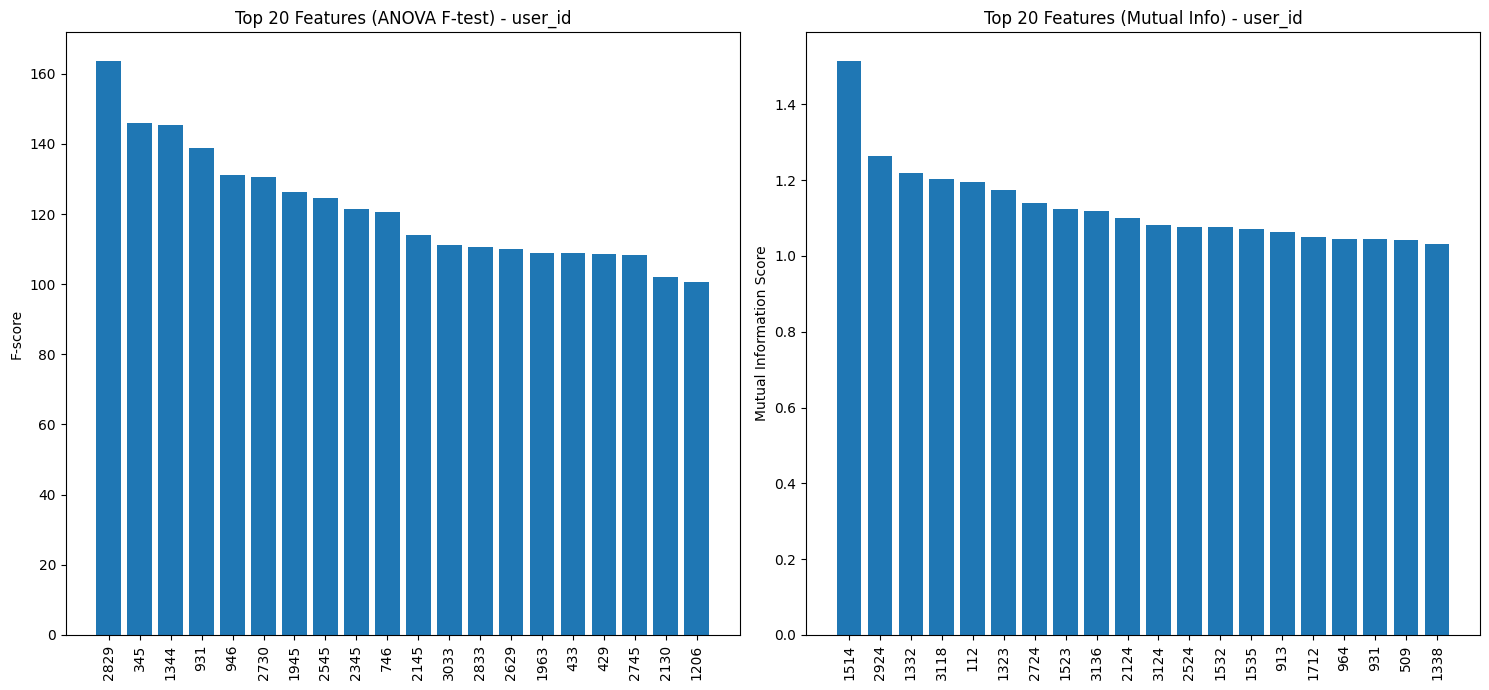

------------------------------
Özellik seçimi (k=500) user_id için f_classif ve mutual_info ile tamamlandı.
------------------------------


In [42]:
try:
    scores_f = selector_f_user.scores_[selector_f_user.get_support()] 
    scores_mi = selector_mi_user.scores_[selector_mi_user.get_support()] 
    
    indices_f_sorted = np.argsort(scores_f)[::-1]
    indices_mi_sorted = np.argsort(scores_mi)[::-1]

    num_features_to_plot = 20 
    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.bar(range(min(num_features_to_plot, k_features)), scores_f[indices_f_sorted][:num_features_to_plot], align='center')
    plt.xticks(range(min(num_features_to_plot, k_features)), selected_features_f_user_names[indices_f_sorted][:num_features_to_plot], rotation=90)
    plt.title(f'Top {num_features_to_plot} Features (ANOVA F-test) - user_id')
    plt.ylabel('F-score')

    plt.subplot(1, 2, 2)
    plt.bar(range(min(num_features_to_plot, k_features)), scores_mi[indices_mi_sorted][:num_features_to_plot], align='center')
    plt.xticks(range(min(num_features_to_plot, k_features)), selected_features_mi_user_names[indices_mi_sorted][:num_features_to_plot], rotation=90)
    plt.title(f'Top {num_features_to_plot} Features (Mutual Info) - user_id')
    plt.ylabel('Mutual Information Score')

    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Görselleştirme sırasında bir hata oluştu (muhtemelen k çok küçük): {e}")


print("-" * 30)
print(f"Özellik seçimi (k={k_features}) user_id için f_classif ve mutual_info ile tamamlandı.")
print("-" * 30)

In [43]:
print(f"\n--- touch_type için Özellik Seçimi (k={k_features}) ---")
print("-" * 30)


--- touch_type için Özellik Seçimi (k=500) ---
------------------------------


In [44]:
print(f"Yöntem 1: SelectKBest (f_classif, k={k_features}) - touch_type için")
selector_f_touch = SelectKBest(score_func=f_classif, k=k_features)

Yöntem 1: SelectKBest (f_classif, k=500) - touch_type için


### Feature Selection for `touch_type` (k=500)
Applying `SelectKBest` with `f_classif` and `mutual_info_classif` (k=500) using `X_train_touch` and `y_train_touch`.

In [45]:
selector_f_touch.fit(X_train_touch, y_train_touch)

SelectKBest(k=500)

In [46]:
X_train_touch_f = selector_f_touch.transform(X_train_touch)
X_test_touch_f = selector_f_touch.transform(X_test_touch)

In [47]:
selected_features_f_touch_names = X_train_touch.columns[selector_f_touch.get_support()]

In [48]:
print(f"Seçilen özellik sayısı (f_classif): {X_train_touch_f.shape[1]}")
print(f"Eğitim verisi boyutu (f_classif sonrası): {X_train_touch_f.shape}")
print(f"Test verisi boyutu (f_classif sonrası): {X_test_touch_f.shape}")
print(f"Seçilen ilk 10 özellik (f_classif): {selected_features_f_touch_names.tolist()[:10]}")
print("-" * 30)


Seçilen özellik sayısı (f_classif): 500
Eğitim verisi boyutu (f_classif sonrası): (1447, 500)
Test verisi boyutu (f_classif sonrası): (483, 500)
Seçilen ilk 10 özellik (f_classif): ['47', '48', '49', '50', '51', '246', '247', '248', '249', '250']
------------------------------


In [49]:
print(f"Yöntem 2: SelectKBest (mutual_info_classif, k={k_features}) - touch_type için")
selector_mi_touch = SelectKBest(score_func=mutual_info_classif, k=k_features)

Yöntem 2: SelectKBest (mutual_info_classif, k=500) - touch_type için


In [50]:
selector_mi_touch.fit(X_train_touch, y_train_touch)


SelectKBest(k=500,
            score_func=<function mutual_info_classif at 0x000001996445E830>)

In [51]:
X_train_touch_mi = selector_mi_touch.transform(X_train_touch)
X_test_touch_mi = selector_mi_touch.transform(X_test_touch)

In [52]:
selected_features_mi_touch_names = X_train_touch.columns[selector_mi_touch.get_support()]

In [53]:
print(f"Seçilen özellik sayısı (mutual_info): {X_train_touch_mi.shape[1]}")
print(f"Eğitim verisi boyutu (mutual_info sonrası): {X_train_touch_mi.shape}")
print(f"Test verisi boyutu (mutual_info sonrası): {X_test_touch_mi.shape}")
print(f"Seçilen ilk 10 özellik (mutual_info): {selected_features_mi_touch_names.tolist()[:10]}")
print("-" * 30)

Seçilen özellik sayısı (mutual_info): 500
Eğitim verisi boyutu (mutual_info sonrası): (1447, 500)
Test verisi boyutu (mutual_info sonrası): (483, 500)
Seçilen ilk 10 özellik (mutual_info): ['174', '177', '192', '297', '299', '350', '352', '353', '355', '356']
------------------------------


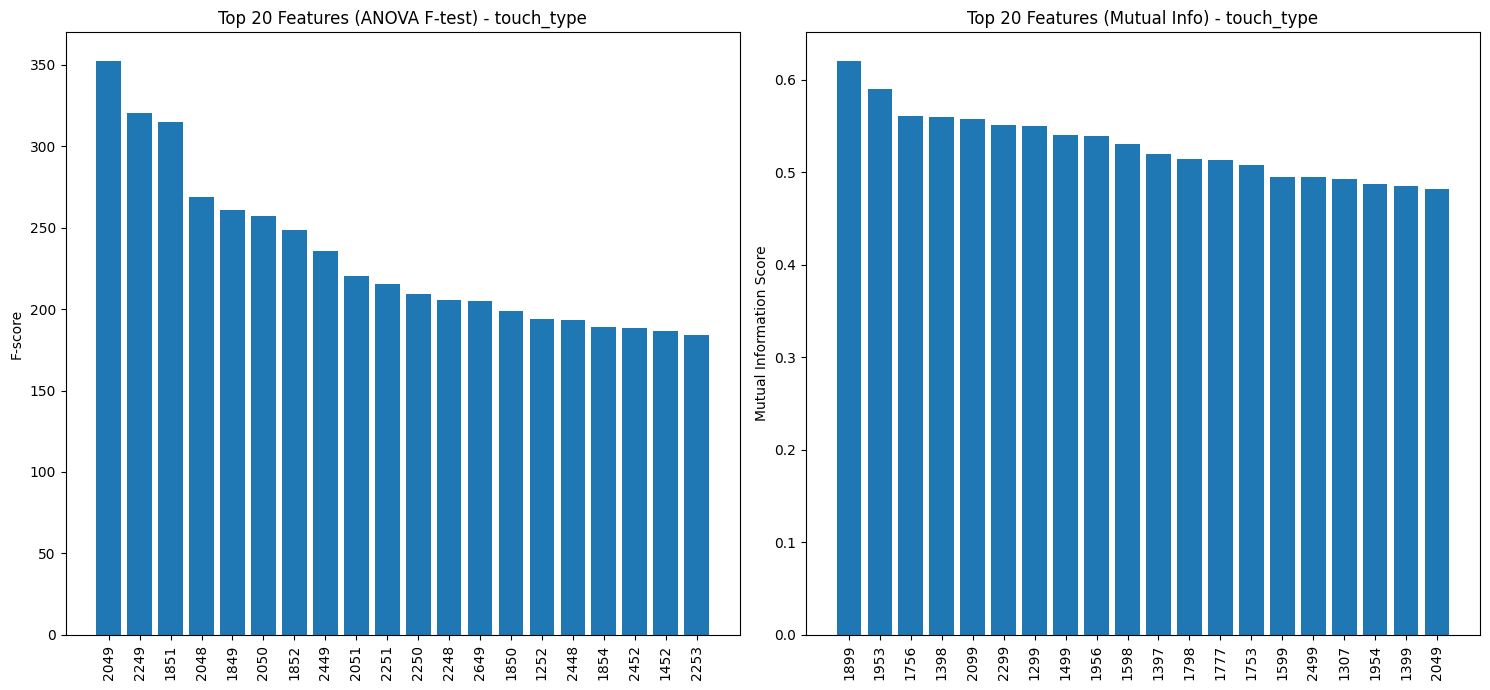

------------------------------
Özellik seçimi (k=500) touch_type için f_classif ve mutual_info ile tamamlandı.


In [54]:
try:
    scores_f_touch = selector_f_touch.scores_[selector_f_touch.get_support()]
    scores_mi_touch = selector_mi_touch.scores_[selector_mi_touch.get_support()]
    indices_f_touch_sorted = np.argsort(scores_f_touch)[::-1]
    indices_mi_touch_sorted = np.argsort(scores_mi_touch)[::-1]

    num_features_to_plot = 20
    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.bar(range(min(num_features_to_plot, k_features)), scores_f_touch[indices_f_touch_sorted][:num_features_to_plot], align='center')
    plt.xticks(range(min(num_features_to_plot, k_features)), selected_features_f_touch_names[indices_f_touch_sorted][:num_features_to_plot], rotation=90)
    plt.title(f'Top {num_features_to_plot} Features (ANOVA F-test) - touch_type')
    plt.ylabel('F-score')

    plt.subplot(1, 2, 2)
    plt.bar(range(min(num_features_to_plot, k_features)), scores_mi_touch[indices_mi_touch_sorted][:num_features_to_plot], align='center')
    plt.xticks(range(min(num_features_to_plot, k_features)), selected_features_mi_touch_names[indices_mi_touch_sorted][:num_features_to_plot], rotation=90)
    plt.title(f'Top {num_features_to_plot} Features (Mutual Info) - touch_type')
    plt.ylabel('Mutual Information Score')

    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Görselleştirme sırasında bir hata oluştu (muhtemelen k çok küçük): {e}")


print("-" * 30)
print(f"Özellik seçimi (k={k_features}) touch_type için f_classif ve mutual_info ile tamamlandı.")

## 4. Initial Model Training and Evaluation (k=500)

Now we train and evaluate several standard classification models using the feature sets selected in the previous step (k=500). This provides a baseline understanding of model performance and helps identify promising combinations of models and feature selection methods.

*   **Models:** Logistic Regression, Random Forest Classifier, Support Vector Classifier (SVC).
*   **Pipelines:** Use `sklearn.pipeline.Pipeline` to combine preprocessing (StandardScaler, especially needed for Logistic Regression and SVC) and the classifier.
*   **Evaluation:** Train models on the respective training sets (`_user_f`, `_user_mi`, `_touch_f`, `_touch_mi`) and evaluate performance on the corresponding test sets using:
    *   Accuracy score.
    *   Classification report (providing precision, recall, F1-score per class, crucial for imbalanced `touch_type`).
*   **Comparison:** Compare performance across models and feature selection methods (`f_classif` vs. `mutual_info`) for both `user_id` and `touch_type` tasks.

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import time 

print("\n4. Madde: Model Geliştirme ve Karşılaştırma")
print("-" * 50)

models = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000, random_state=42, solver='saga', multi_class='auto'))
    ]),
    "Random Forest": Pipeline([
        ('clf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
    ]),
    "SVC": Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(random_state=42, probability=False))
    ])
}

data_scenarios = {
    "User ID (f_classif)": {
        "X_train": X_train_user_f, "y_train": y_train_user,
        "X_test": X_test_user_f, "y_test": y_test_user
    },
    "User ID (mutual_info)": {
        "X_train": X_train_user_mi, "y_train": y_train_user,
        "X_test": X_test_user_mi, "y_test": y_test_user
    },
    "Touch Type (f_classif)": {
        "X_train": X_train_touch_f, "y_train": y_train_touch,
        "X_test": X_test_touch_f, "y_test": y_test_touch
    },
    "Touch Type (mutual_info)": {
        "X_train": X_train_touch_mi, "y_train": y_train_touch,
        "X_test": X_test_touch_mi, "y_test": y_test_touch
    }
}

results = {}

for scenario_name, data in data_scenarios.items():
    print(f"\n===== Senaryo: {scenario_name} =====")
    results[scenario_name] = {}
    X_train = data["X_train"]
    y_train = data["y_train"]
    X_test = data["X_test"]
    y_test = data["y_test"]

    print(f"Eğitim verisi boyutu: {X_train.shape}")
    print(f"Test verisi boyutu: {X_test.shape}")
    print("-" * 30)

    for model_name, model_pipeline in models.items():
        print(f"--- Model: {model_name} ---")

        start_time = time.time()

        try:
            model_pipeline.fit(X_train, y_train)
            fit_time = time.time() - start_time

            start_time_pred = time.time()
            y_pred = model_pipeline.predict(X_test)
            pred_time = time.time() - start_time_pred

            accuracy = accuracy_score(y_test, y_pred)
            report = classification_report(y_test, y_pred, zero_division=0)

            print(f"Eğitim Süresi: {fit_time:.2f} saniye")
            print(f"Tahmin Süresi: {pred_time:.2f} saniye")
            print(f"Test Seti Doğruluğu (Accuracy): {accuracy:.4f}")
            print("Sınıflandırma Raporu:")
            print(report)

            results[scenario_name][model_name] = {'accuracy': accuracy, 'report': report, 'fit_time': fit_time}

        except Exception as e:
            print(f"HATA: {model_name} modeli eğitilirken/tahmin yapılırken bir sorun oluştu: {e}")
            results[scenario_name][model_name] = {'accuracy': None, 'report': str(e), 'fit_time': None}

        print("-" * 30)

print("\n4. Madde (Model Geliştirme ve Karşılaştırma) tamamlandı.")
print("5. Madde: Sonuçların Değerlendirilmesi (Yukarıdaki çıktılara göre yapılacak)")
print("-" * 50)


4. Madde: Model Geliştirme ve Karşılaştırma
--------------------------------------------------

===== Senaryo: User ID (f_classif) =====
Eğitim verisi boyutu: (1447, 500)
Test verisi boyutu: (483, 500)
------------------------------
--- Model: Logistic Regression ---


C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Eğitim Süresi: 41.59 saniye
Tahmin Süresi: 0.02 saniye
Test Seti Doğruluğu (Accuracy): 1.0000
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00        13
           5       1.00      1.00      1.00        19
           6       1.00      1.00      1.00        19
           7       1.00      1.00      1.00        23
           8       1.00      1.00      1.00        16
           9       1.00      1.00      1.00        15
          10       1.00      1.00      1.00        19
          11       1.00      1.00      1.00        15
          12       1.00      1.00      1.00        14
          13       1.00      1.00      1.00        17
          14       1.00      1.00      1.00        13
          15       

C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Eğitim Süresi: 41.30 saniye
Tahmin Süresi: 0.00 saniye
Test Seti Doğruluğu (Accuracy): 1.0000
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00        13
           5       1.00      1.00      1.00        19
           6       1.00      1.00      1.00        19
           7       1.00      1.00      1.00        23
           8       1.00      1.00      1.00        16
           9       1.00      1.00      1.00        15
          10       1.00      1.00      1.00        19
          11       1.00      1.00      1.00        15
          12       1.00      1.00      1.00        14
          13       1.00      1.00      1.00        17
          14       1.00      1.00      1.00        13
          15       

C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Eğitim Süresi: 16.66 saniye
Tahmin Süresi: 0.00 saniye
Test Seti Doğruluğu (Accuracy): 0.6812
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       280
           1       0.57      0.57      0.57        23
           2       0.52      0.48      0.50        23
           3       0.16      0.18      0.17        22
           4       0.05      0.05      0.05        20
           5       0.47      0.43      0.45        21
           6       0.42      0.36      0.39        22
           7       0.52      0.50      0.51        24
           8       0.54      0.73      0.62        26
           9       0.22      0.18      0.20        22

    accuracy                           0.68       483
   macro avg       0.44      0.44      0.43       483
weighted avg       0.68      0.68      0.68       483

------------------------------
--- Model: Random Forest ---
Eğitim Süresi: 0.33 saniye
Tahmin Süresi: 0.03 saniye
Test Seti D

C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Eğitim Süresi: 16.52 saniye
Tahmin Süresi: 0.00 saniye
Test Seti Doğruluğu (Accuracy): 0.6398
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       280
           1       0.38      0.43      0.41        23
           2       0.30      0.26      0.28        23
           3       0.12      0.09      0.10        22
           4       0.11      0.10      0.11        20
           5       0.27      0.29      0.28        21
           6       0.25      0.23      0.24        22
           7       0.29      0.17      0.21        24
           8       0.54      0.50      0.52        26
           9       0.18      0.18      0.18        22

    accuracy                           0.64       483
   macro avg       0.33      0.32      0.32       483
weighted avg       0.61      0.64      0.63       483

------------------------------
--- Model: Random Forest ---
Eğitim Süresi: 0.27 saniye
Tahmin Süresi: 0.03 saniye
Test Seti D

## 5. Evaluation of Initial Models (k=500) and Path to Optimization

Based on the results from Step 4:

*   **`user_id` Task:** All tested models achieved **perfect 100% accuracy** on the test set with k=500 features (using both `f_classif` and `mutual_info`). This indicates the task is relatively easy with this many features, and users have distinct touch signatures. Random Forest and SVC were significantly faster to train than Logistic Regression.
*   **`touch_type` Task:** Performance was much lower (best accuracy ~76%). `f_classif` generally yielded better results than `mutual_info`. SVC and Random Forest had the highest accuracy, but the classification reports revealed they **failed completely** on some minority classes (e.g., classes 3 and 4 had F1-scores of 0.00). This highlights the challenge posed by class imbalance.

**Decision:** Given the perfect score for `user_id`, further optimization seems unnecessary for that task with k=500. However, the `touch_type` task clearly needs improvement, especially for minority classes. We will focus on optimizing the `touch_type` prediction. We select the **Random Forest** model with **`f_classif`** features as the most promising combination to optimize further using Grid Search, aiming to find the best `k` and model hyperparameters, particularly focusing on improving the macro F1-score.

## 6. Optimization via Grid Search for `touch_type`

To find the optimal number of features (`k`) and the best hyperparameters for the Random Forest model on the `touch_type` task, we employ `GridSearchCV`.

*   **Pipeline:** Create a pipeline: `SelectKBest(f_classif)` -> `StandardScaler` -> `RandomForestClassifier`.
*   **Parameter Grid:** Define a grid of parameters to search over:
    *   `selector__k`: Various values for the number of features to select (e.g., 100, 200, 500, 800, 1000).
    *   `classifier__<hyperparameter>`: Key hyperparameters for RandomForest (e.g., `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`, `class_weight`).
*   **Scoring Metric:** Use `'f1_macro'` as the scoring metric within `GridSearchCV`. This metric gives equal weight to all classes, making it suitable for evaluating performance on imbalanced datasets and encouraging improvement for minority classes.
*   **Execution:** Run `GridSearchCV` using 5-fold cross-validation on the **original training data (`X_train_touch`, `y_train_touch`)**. The `SelectKBest` step within the pipeline handles the feature selection for each `k` value internally.
*   **Result:** Identify the best parameters (`best_params_`) and the corresponding best cross-validation score (`best_score_`).

In [56]:
import time
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

print("\n6. Madde: Grid Search ile Optimizasyon (touch_type, f_classif, RandomForest)")
print("-" * 60)

pipeline_rf = Pipeline([
    ('selector', SelectKBest(score_func=f_classif)),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_grid_rf = {
    'selector__k': [100, 200, 500, 800, 1000], 
    'classifier__n_estimators': [100, 200],    
    'classifier__max_depth': [None, 10, 20],   
    'classifier__min_samples_split': [2, 5],   
    'classifier__min_samples_leaf': [1, 3],   
    'classifier__class_weight': [None, 'balanced'] 
}

grid_search_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid_rf,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=2
)

print("Grid Search başlıyor (Bu işlem biraz zaman alabilir)...")
start_time_grid = time.time()

grid_search_rf.fit(X_train_touch, y_train_touch)

end_time_grid = time.time()
print(f"Grid Search tamamlandı. Süre: {(end_time_grid - start_time_grid):.2f} saniye")
print("-" * 30)

print("En İyi Parametreler:")
print(grid_search_rf.best_params_)
print("-" * 30)

print(f"En İyi Cross-Validation Skoru ({grid_search_rf.scoring}):")
print(f"{grid_search_rf.best_score_:.4f}")
print("-" * 30)

print("En İyi Modelin Test Seti Performansı:")

best_rf_model = grid_search_rf.best_estimator_

y_pred_test_best_rf = best_rf_model.predict(X_test_touch)

accuracy_test_best_rf = accuracy_score(y_test_touch, y_pred_test_best_rf)
report_test_best_rf = classification_report(y_test_touch, y_pred_test_best_rf, zero_division=0)

print(f"Test Seti Doğruluğu: {accuracy_test_best_rf:.4f}")
print("Test Seti Sınıflandırma Raporu:")
print(report_test_best_rf)
print("-" * 60)


6. Madde: Grid Search ile Optimizasyon (touch_type, f_classif, RandomForest)
------------------------------------------------------------
Grid Search başlıyor (Bu işlem biraz zaman alabilir)...
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Grid Search tamamlandı. Süre: 301.03 saniye
------------------------------
En İyi Parametreler:
{'classifier__class_weight': None, 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200, 'selector__k': 100}
------------------------------
En İyi Cross-Validation Skoru (f1_macro):
0.5422
------------------------------
En İyi Modelin Test Seti Performansı:
Test Seti Doğruluğu: 0.7660
Test Seti Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.84      0.99      0.90       280
           1       0.52      0.52      0.52        23
           2       0.44      0.30      0.36        23
           3       1.00      

## 7. Final Model Evaluation and Analysis

We now evaluate the best model found by Grid Search on the held-out test set and perform final analyses.

1.  **Best Model Performance:** Report the accuracy and classification report for the `best_estimator_` from Grid Search applied to the test set (`X_test_touch`, `y_test_touch`). Analyze improvements, especially for minority classes, compared to the initial k=500 models.
2.  **Confusion Matrix:** Generate and visualize the confusion matrix for:
    *   The best `user_id` model (k=500, e.g., RF) to confirm perfect classification.
    *   The best `touch_type` model (from Grid Search) to visualize which classes are still being confused.
3.  **Feature Importances:** Extract and visualize the feature importances from the best `touch_type` Random Forest model. This shows which of the selected `k` sensors were most influential in the model's predictions.
4.  **Performance vs. Feature Count:** Plot the `f1_macro` score (obtained from `cv_results_`) against the different `k` values tested during Grid Search. This visually demonstrates the accuracy vs. feature count trade-off and justifies the choice of the optimal `k`.


Ek Analiz Adım 1: Karışıklık Matrisleri
--------------------------------------------------
user_id için Karışıklık Matrisi oluşturuluyor...


<Figure size 1000x800 with 0 Axes>

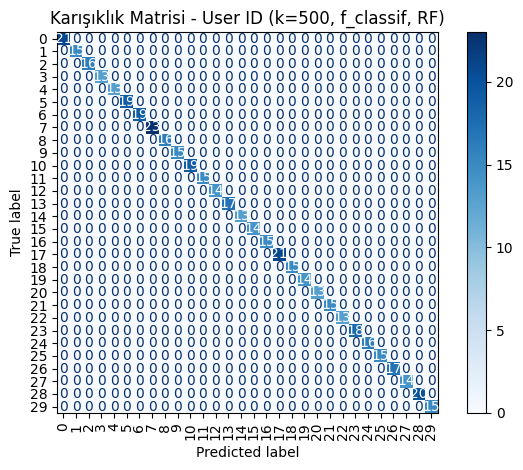

User ID için karışıklık matrisi görselleştirildi.
------------------------------
touch_type için Karışıklık Matrisi oluşturuluyor...


<Figure size 800x600 with 0 Axes>

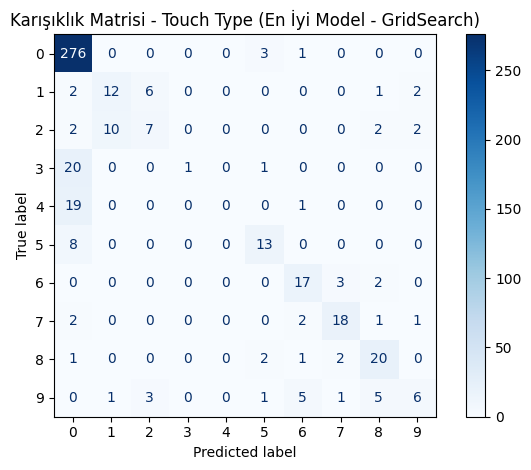

Touch Type için karışıklık matrisi görselleştirildi.
--------------------------------------------------


In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

print("\nEk Analiz Adım 1: Karışıklık Matrisleri")
print("-" * 50)

print("user_id için Karışıklık Matrisi oluşturuluyor...")

model_user_id_best = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model_user_id_best.fit(X_train_user_f, y_train_user)
y_pred_user_best = model_user_id_best.predict(X_test_user_f)

cm_user = confusion_matrix(y_test_user, y_pred_user_best)

user_classes = sorted(y_user.unique())

plt.figure(figsize=(10, 8))
disp_user = ConfusionMatrixDisplay(confusion_matrix=cm_user, display_labels=user_classes)
disp_user.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Karışıklık Matrisi - User ID (k=500, f_classif, RF)')
plt.tight_layout()
plt.show()

print("User ID için karışıklık matrisi görselleştirildi.")
print("-" * 30)

print("touch_type için Karışıklık Matrisi oluşturuluyor...")

cm_touch = confusion_matrix(y_test_touch, y_pred_test_best_rf)

touch_classes = sorted(y_touch.unique()) 

plt.figure(figsize=(8, 6))
disp_touch = ConfusionMatrixDisplay(confusion_matrix=cm_touch, display_labels=touch_classes)
disp_touch.plot(cmap=plt.cm.Blues) 
plt.title('Karışıklık Matrisi - Touch Type (En İyi Model - GridSearch)')
plt.tight_layout()
plt.show()

print("Touch Type için karışıklık matrisi görselleştirildi.")
print("-" * 50)


Ek Analiz Adım 2: Özellik Önem Sıralaması (En İyi Touch Type Modeli)
------------------------------------------------------------
En Önemli Özellikler (Touch Type - En İyi Model):
   Feature  Importance
60    2249    0.042709
43    2049    0.040765
62    2251    0.036409
29    1851    0.029578
75    2449    0.024362
44    2050    0.022866
9     1252    0.022851
88    2649    0.022612
27    1849    0.022033
61    2250    0.021604
59    2248    0.019562
74    2448    0.019492
30    1852    0.018651
42    2048    0.017650
28    1850    0.016465
45    2051    0.015715
8     1251    0.014880
76    2450    0.014580
39    1873    0.014576
32    1854    0.012649
------------------------------


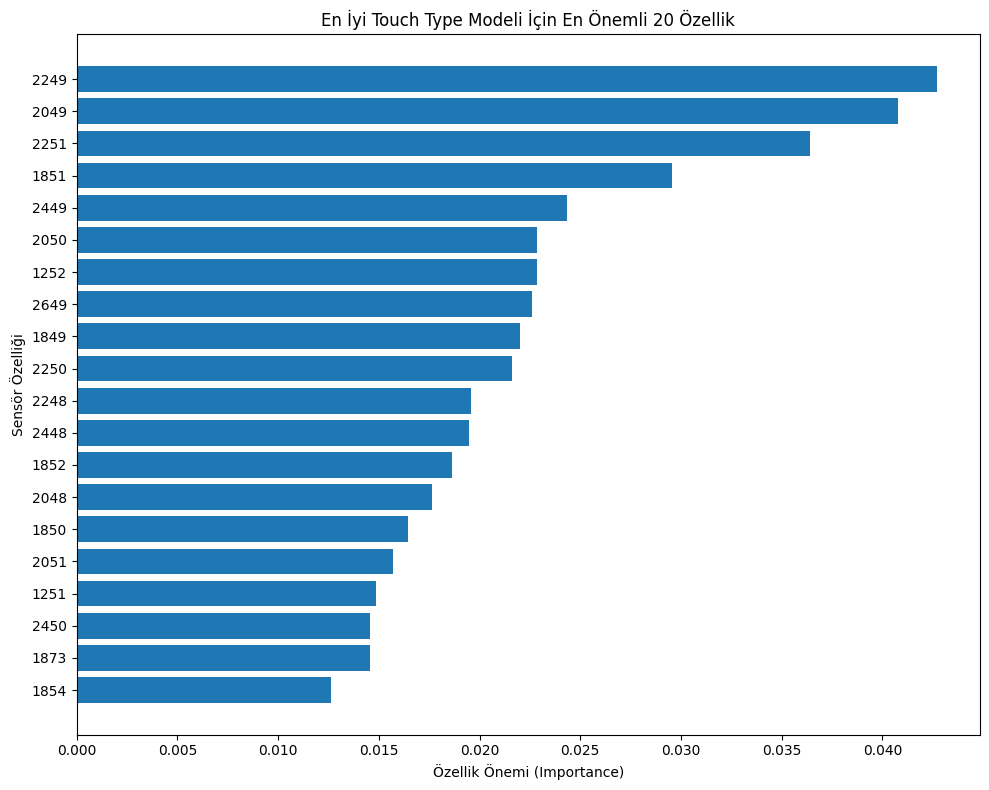

En önemli 20 özelliğin grafiği çizildi.


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("\nEk Analiz Adım 2: Özellik Önem Sıralaması (En İyi Touch Type Modeli)")
print("-" * 60)

try:
    rf_classifier_step = best_rf_model.named_steps['classifier']

    importances = rf_classifier_step.feature_importances_

    selector_step = best_rf_model.named_steps['selector']

    selected_features_mask = selector_step.get_support()

    if isinstance(X_train_touch, pd.DataFrame):
        original_feature_names = X_train_touch.columns
    else:
        
        try:
             original_feature_names = X.columns
        except AttributeError:
             print("UYARI: Orijinal özellik isimleri DataFrame'den alınamadı. Varsayılan isimler kullanılacak.")
             original_feature_names = [f"feat_{i}" for i in range(X_train_touch.shape[1])]


    selected_feature_names = original_feature_names[selected_features_mask]

    if len(selected_feature_names) == len(importances):
        feature_importance_df = pd.DataFrame({
            'Feature': selected_feature_names,
            'Importance': importances
        })

        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

        print("En Önemli Özellikler (Touch Type - En İyi Model):")
        print(feature_importance_df.head(20))
        print("-" * 30)

        n_to_plot = 20
        plt.figure(figsize=(10, 8))
        plt.barh(feature_importance_df['Feature'][:n_to_plot], feature_importance_df['Importance'][:n_to_plot], align='center')
        plt.xlabel('Özellik Önemi (Importance)')
        plt.ylabel('Sensör Özelliği')
        plt.title(f'En İyi Touch Type Modeli İçin En Önemli {n_to_plot} Özellik')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        print(f"En önemli {n_to_plot} özelliğin grafiği çizildi.")

    else:
        print(f"HATA: Seçilen özellik sayısı ({len(selected_feature_names)}) ile önem skoru sayısı ({len(importances)}) eşleşmiyor!")

except KeyError as e:
    print(f"HATA: Pipeline adımları ('selector' veya 'classifier') bulunamadı: {e}")
except AttributeError as e:
    print(f"HATA: Özellik önemleri alınamadı veya özellik isimleri DataFrame'den okunamadı: {e}")
except Exception as e:
    print(f"Beklenmeyen bir hata oluştu: {e}")



Ek Analiz Adım 3: Performans vs. Özellik Sayısı (k) Grafiği
------------------------------------------------------------
Farklı k değerleri için en iyi CV f1_macro skorları:
     param_selector__k  mean_test_score
15                 100         0.542158
6                  200         0.531678
187                500         0.508848
148                800         0.475390
189               1000         0.476059
------------------------------


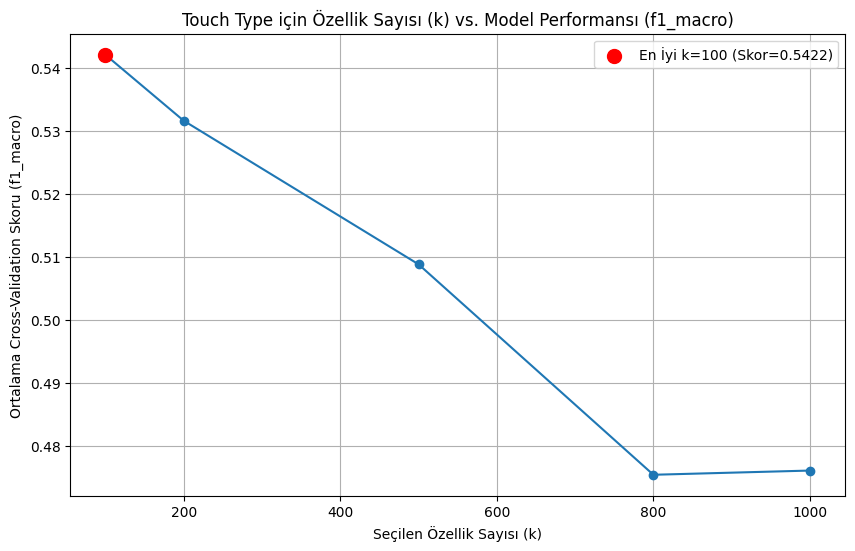

Performans vs k grafiği çizildi. En iyi performans k=100 ile elde edildi.


In [59]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("\nEk Analiz Adım 3: Performans vs. Özellik Sayısı (k) Grafiği")
print("-" * 60)

results_df = pd.DataFrame(grid_search_rf.cv_results_)

results_df['param_selector__k'] = pd.to_numeric(results_df['param_selector__k'])

best_score_per_k = results_df.loc[results_df.groupby('param_selector__k')['mean_test_score'].idxmax()]

best_score_per_k = best_score_per_k[['param_selector__k', 'mean_test_score']].sort_values('param_selector__k')


print("Farklı k değerleri için en iyi CV f1_macro skorları:")
print(best_score_per_k)
print("-" * 30)

plt.figure(figsize=(10, 6))
plt.plot(best_score_per_k['param_selector__k'], best_score_per_k['mean_test_score'], marker='o', linestyle='-')

best_k = grid_search_rf.best_params_['selector__k']
best_score = grid_search_rf.best_score_
plt.scatter([best_k], [best_score], color='red', s=100, label=f'En İyi k={best_k} (Skor={best_score:.4f})', zorder=5) # zorder en üste çıkarır

plt.xlabel("Seçilen Özellik Sayısı (k)")
plt.ylabel(f"Ortalama Cross-Validation Skoru ({grid_search_rf.scoring})")
plt.title("Touch Type için Özellik Sayısı (k) vs. Model Performansı (f1_macro)")
plt.grid(True)
plt.legend()
plt.show()

print(f"Performans vs k grafiği çizildi. En iyi performans k={best_k} ile elde edildi.")

## 8. Conclusion

Summarize the key findings of the project:

*   Successfully built separate models for `user_id` and `touch_type` classification.
*   Adhered to constraints by using feature selection (`SelectKBest` with `f_classif`/`mutual_info`) instead of dimensionality reduction.
*   **`user_id` Classification:** Achieved perfect (100%) accuracy with k=500 features, indicating high user distinguishability.
*   **`touch_type` Classification:** Proved more challenging due to class imbalance. Grid Search optimization using `f_classif` and RandomForest identified `k=100` as the optimal feature count based on `f1_macro` score.
    *   The optimized model achieved ~76.6% accuracy and a macro F1-score of ~0.50 on the test set.
    *   Significant improvement over k=500 baseline in terms of efficiency (fewer features) and slight improvement in macro F1, but challenges remain, particularly in identifying certain minority classes (e.g., class 4).
*   **Feature Selection Effectiveness:** Demonstrated that feature selection is crucial for handling high-dimensional data, significantly reducing the feature set (`k=100` for touch type) while maintaining or slightly improving performance. The optimal `k` depends on the task.